# MNIST Autoencoders in Keras (WIP) - Ken Chua
## 1. Autoencoder
Autoencoders use one neural network (called the "encoder") to process some input x into a smaller representation z,  for such purposes as compression and denoising. For training purposes (and decompression), a second network (called the "decoder") is used to grow z back to the original input dimension. The output of the decoder is diffed against the original input to the encoder and taken as loss to train the entire model.
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png" />
The following CNN-based autoencoder for MNIST digits has a 98:9 compression ratio (28x28x1 pixels to 3x3x8) with mean absolute error (MAE) of only 0.025 on the test set.

In [1]:
from keras import backend as K
from keras import metrics
from keras import Model
from keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, Dense, ELU, Flatten, Input, Lambda, MaxPooling2D, Reshape, UpSampling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import mnistutils as mnist
import numpy as np
import plotutils as pu
from scipy.stats import norm

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
BATCH_SIZE = 512
EPOCHS = 50

In [4]:
train_x, _, dev_x, _, test_x, test_y = mnist.load()

train_x = mnist.normalize(train_x)
dev_x = mnist.normalize(dev_x)
test_x = mnist.normalize(test_x)

In [5]:
def model_encoder():
    X_input = Input(shape=(mnist.IMAGE_WIDTH, mnist.IMAGE_WIDTH, mnist.CHANNEL_COUNT))
    X = Conv2D(filters=32, kernel_size=3)(X_input)
    X = BatchNormalization()(X)
    X = ELU()(X)
    X = MaxPooling2D(2)(X)
    X = Conv2D(filters=16, kernel_size=3)(X)
    X = BatchNormalization()(X)
    X = ELU()(X)
    X = MaxPooling2D(2)(X)
    X = Conv2D(filters=8, kernel_size=3, activation='elu')(X)
    return Model(inputs=X_input, outputs=X, name='encoder')

In [6]:
encoder = model_encoder()
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
elu_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 16)        64        
__________

In [7]:
def model_decoder():
    X_input = Input(shape=(3, 3, 8))
    X = Conv2DTranspose(filters=8, kernel_size=3)(X_input)
    X = BatchNormalization()(X)
    X = ELU()(X)
    X = UpSampling2D(2)(X)
    X = Conv2DTranspose(filters=16, kernel_size=4)(X)
    X = BatchNormalization()(X)
    X = ELU()(X)
    X = UpSampling2D(2)(X)
    X = Conv2DTranspose(filters=mnist.CHANNEL_COUNT, kernel_size=3, activation='sigmoid')(X)
    return Model(inputs=X_input, outputs=X, name='decoder')

In [8]:
decoder = model_decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 3, 8)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 8)           584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 8)           32        
_________________________________________________________________
elu_3 (ELU)                  (None, 5, 5, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 13, 13, 16)        2064      
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 16)        64        
__________

In [9]:
def model_autoencoder(encoder, decoder):
    X_input = encoder.inputs
    X = encoder(X_input)
    X = decoder(X)
    return Model(inputs=X_input, outputs=X)

In [10]:
autoencoder = model_autoencoder(encoder, decoder)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 3, 3, 8)           6296      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         2889      
Total params: 9,185
Trainable params: 9,041
Non-trainable params: 144
_________________________________________________________________


Simply inputting the training data as <code>y</code> (as well as <code>x</code>) will perform the diff to calculate the loss for training:

In [114]:
autoencoder_history = autoencoder.fit(x=train_x, y=train_x, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
                                      validation_data=(dev_x, dev_x))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0922 - mean_absolute_error: 0.2442 - val_loss: 0.0482 - val_mean_absolute_error: 0.1528
Epoch 2/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.0307 - mean_absolute_error: 0.1058 - val_loss: 0.0356 - val_mean_absolute_error: 0.1079
Epoch 3/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.0226 - mean_absolute_error: 0.0776 - val_loss: 0.0269 - val_mean_absolute_error: 0.0845
Epoch 4/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.0190 - mean_absolute_error: 0.0650 - val_loss: 0.0228 - val_mean_absolute_error: 0.0723
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.0168 - mean_absolute_error: 0.0576 - val_loss: 0.0192 - val_mean_absolute_error: 0.0629
Epoch 6/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.0151 - mean_absolute_err

Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.0073 - mean_absolute_error: 0.0289 - val_loss: 0.0073 - val_mean_absolute_error: 0.0284
Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.0073 - mean_absolute_error: 0.0288 - val_loss: 0.0073 - val_mean_absolute_error: 0.0291


In [115]:
print("MAE: {0:.2g}".format(autoencoder.evaluate(x=test_x, y=test_x, batch_size=BATCH_SIZE)[1]))

10000/10000 [==============================] - 0s 19us/step
MAE: 0.029


In [154]:
def compare_autoencoded_mnist_digits(original_images, encoded_images, decoded_images):
    count = len(decoded_images)
    plt.style.use('default')
    plt.figure(figsize=(11, 3.5))  
    plt.gray()
    for i in range(count):
        row = plt.subplot(3, count, i+1)
        plt.imshow(original_images[i].reshape(mnist.IMAGE_WIDTH, mnist.IMAGE_WIDTH))
        row.get_xaxis().set_visible(False)
        row.get_yaxis().set_visible(False)

        row = plt.subplot(3, count, count + i+1)
        plt.imshow(encoded_images[i].reshape(9, 8))  # is actually 3x3x8, but flatten to 9x8 to visualize
        row.get_xaxis().set_visible(False)
        row.get_yaxis().set_visible(False)

        row = plt.subplot(3, count, 2*count + i+1)
        plt.imshow(decoded_images[i].reshape(mnist.IMAGE_WIDTH, mnist.IMAGE_WIDTH))
        row.get_xaxis().set_visible(False)
        row.get_yaxis().set_visible(False)
    plt.show()

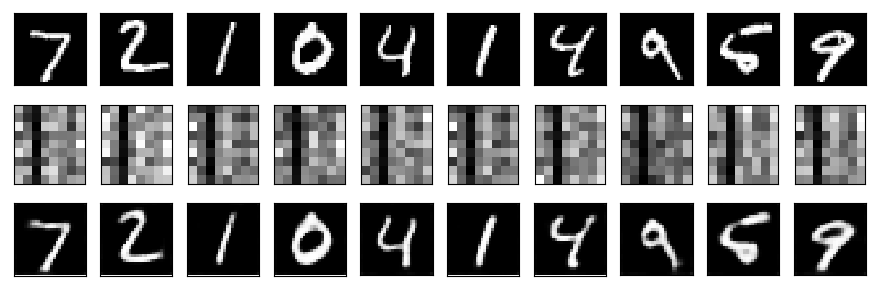

In [155]:
original_images = test_x[:10]
encoded_images = encoder.predict(original_images)
decoded_images = decoder.predict(encoded_images)
compare_autoencoded_mnist_digits(original_images, encoded_images, decoded_images)

These are some digits from our test set before and after compression (top and middle rows, respectively), and also after decompression (bottom row). We can see that the lossiness is minimal.